## CNN inference example

Template example of running a TensorFlow 1-D CNN model for wet–dry classification. By default, the model is pre-trained on a dataset from Czechia.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pycomlink as pycml
# importation of the submodule for running the inference 
from pycomlink.processing.tensorflow_utils import run_inference

In [3]:
# suppress tensorflow verbose logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# print tensorflow, cuda and cudnn versions
print("TensorFlow version:", tf.__version__)
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("CUDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])
# print available GPU devices
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))
# warn if no GPU is available or the cudnn version is not 8
if not tf.config.list_physical_devices('GPU'):
    print("Warning: No GPU devices available.")
if tf.sysconfig.get_build_info()["cudnn_version"] != "8":
    print("Warning: CUDNN compatibility is only tested for version 8. Please ensure compatibility.")

TensorFlow version: 2.17.0
CUDA version: 12.0
CUDNN version: 8
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load data

data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [5]:
cmls["tl1"] = cmls["tl"].sel(channel_id = 'channel_1')
cmls["tl2"] = cmls["tl"].sel(channel_id = 'channel_2')

## CNN inference 

In [ ]:
results = run_inference.wet_dry_1d_cnn(ds=cmls, return_ds=False)

In [7]:
# storing the probabilities  predictions of the cnn model 
cmls["CNN"] = results

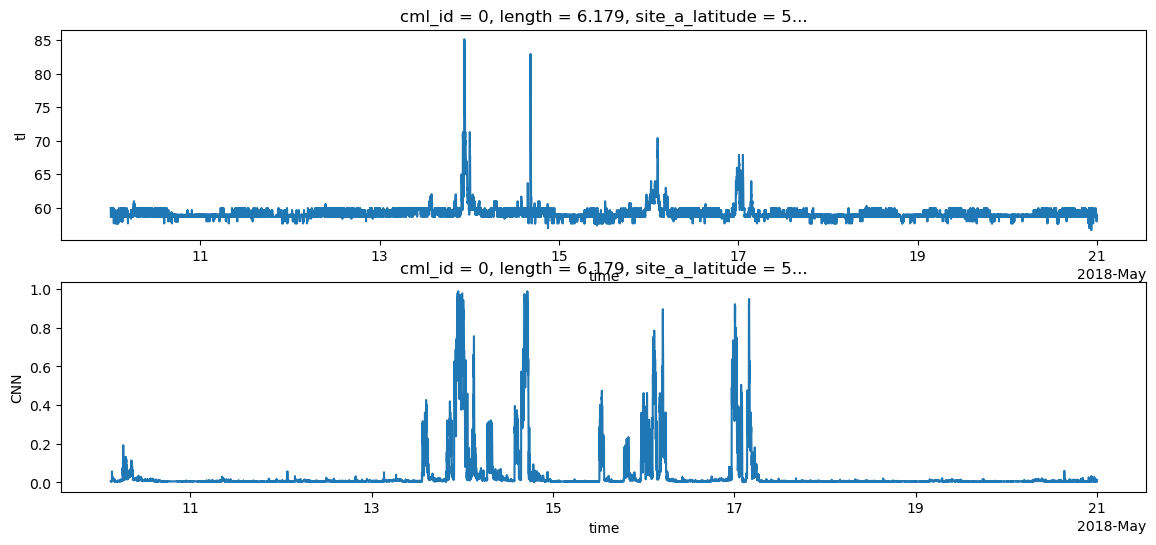

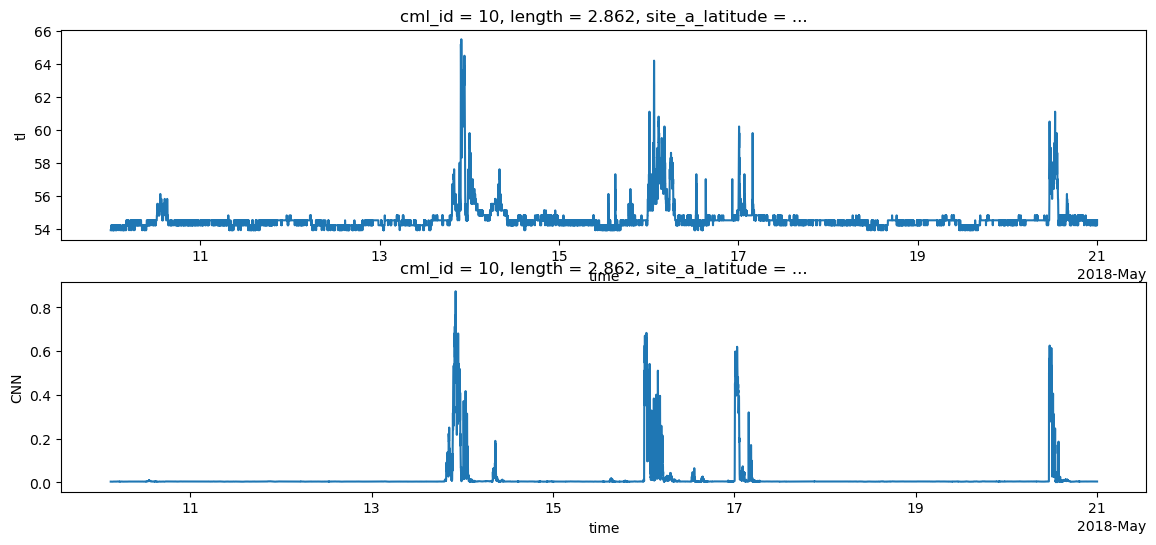

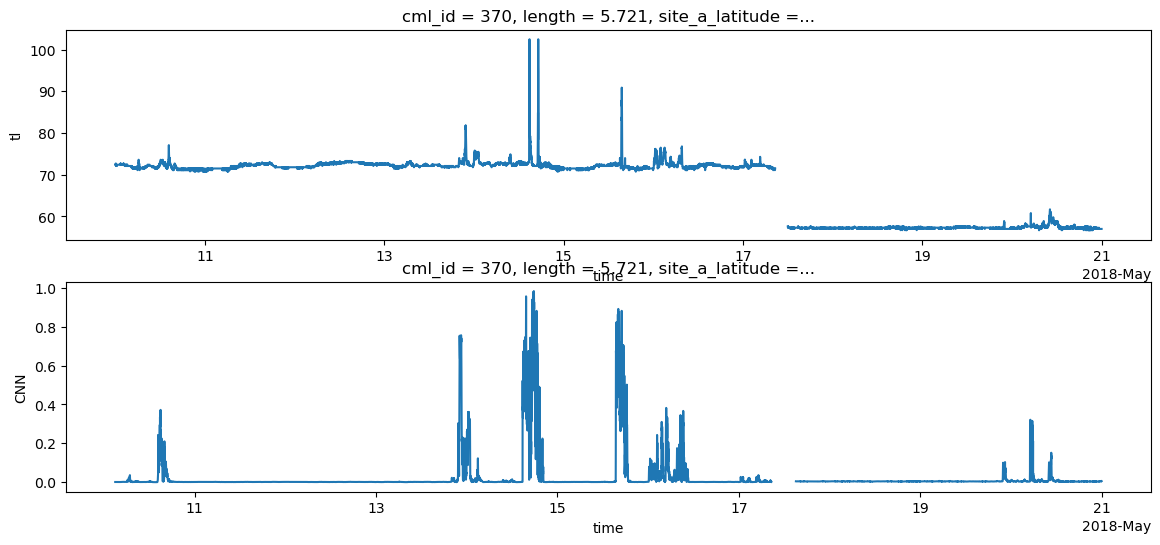

In [8]:
# plotting the results 
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    cmls.tl.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    cmls.CNN.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    
